In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel 
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import json 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

from pathlib import Path
from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from functools import partial
import matplotlib.pyplot as plt

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [15]:
datapath = Path('/home/mrizhko/AML/AstroML/data/asaasn')
ds_train = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True, recalc_period=False, 
                                prime=True, use_bands=['v'], only_sources_with_spectra=False, return_phased=True, 
                                fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Limiting the amount of objects for each class to be no more than 20000 based on v band target... Left with 154604. done.
Total: 154604, Train: 123683, Val: 15460, Test: 15461
Priming tarballs by doing initial scan... done.


In [17]:
ds_val = ASASSNVarStarDataset(datapath, mode='val', verbose=True, only_periodic=True, recalc_period=False, 
                              prime=True, use_bands=['v'], only_sources_with_spectra=False, return_phased=True, 
                              fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening spectra csv... done.
Removing duplicates for v band... Left with 675811. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 459022. done.
Removed non-periodic sources. Now 458988 sources.
Limiting the amount of objects for each class to be no more than 20000 based on v band target... Left with 154604. done.
Total: 154604, Train: 123683, Val: 15460, Test: 15461
Priming tarballs by doing initial scan... done.


In [18]:
no_spectra_data_keys = ['lcs', 'classes']
no_spectra_collate_fn = partial(collate_fn, data_keys=no_spectra_data_keys, fill_value=0)

train_dataloader = DataLoader(ds_train, batch_size=512, shuffle=True, num_workers=8, 
                              collate_fn=no_spectra_collate_fn)
val_dataloader = DataLoader(ds_val, batch_size=512, shuffle=False, collate_fn=no_spectra_collate_fn)

In [19]:
context_length = 200

In [20]:
def preprocess_batch(batch, masks):
    lcs, classes = batch
    lcs_mask, classes_mask = masks

    # shape now [128, 1, 3, 759], make [128, 3, 759] 
    X = lcs[:, 0, :, :]
    
    # change axises, shape now [128, 3, 759], make [128, 759, 3]
    X = X.transpose(1, 2)
    
    # since mask is the same for time flux and flux err we can make it 2D
    mask = lcs_mask[:, 0, 0, :]

    # context length 200, crop X and MASK if longer, pad if shorter
    if X.shape[1] < context_length:
        X_padding = (0, 0, 0, context_length - X.shape[1], 0, 0)
        mask_padding = (0, context_length - X.shape[1])
        X = F.pad(X, X_padding)
        mask = F.pad(mask, mask_padding, value=True)
    else:
        X = X[:, :context_length, :]
        mask = mask[:, :context_length]

    # the last dimention is (time, flux, flux_err), sort it based on time
    sort_indices = torch.argsort(X[:, :, 0], dim=1)
    sorted_X = torch.zeros_like(X)
    
    for i in range(X.shape[0]):
        sorted_X[i] = X[i, sort_indices[i]]
    
    # rearange indexes for masks as well
    sorted_mask = torch.zeros_like(mask)
    
    for i in range(mask.shape[0]):
        sorted_mask[i] = mask[i, sort_indices[i]]

    # mask should be 1 for values that are observed and 0 for values that are missing
    sorted_mask = 1 - sorted_mask.int()

    # read scales
    with open('scales.json', 'r') as f:
        scales = json.load(f)
        mean, std = scales['v']['mean'], scales['v']['std']

    # scale X
    sorted_X[:, :, 1] = (sorted_X[:, :, 1] - mean) / std
    sorted_X[:, :, 2] = sorted_X[:, :, 2] / std

    # reshape classes to be 1D vector and convert from float to int
    classes = classes[:, 0]
    classes = classes.long()
    
    return sorted_X, sorted_mask, classes

In [9]:
batch, masks = next(iter(train_dataloader))

In [10]:
X, m, y = preprocess_batch(batch, masks)

In [29]:
config = TimeSeriesTransformerConfig(
    prediction_length=20,    # doesn't matter but it's required by hf
    context_length=context_length,
    num_time_features=1,
    num_static_real_features=0,
    encoder_layers=2,
    d_model=128,
    distribution_output='normal',
    scaling=None,
    dropout=0,
    encoder_layerdrop=0,
    attention_dropout=0,
    activation_dropout=0
)

config.feature_size = 2    # flux and flux err

In [22]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda:7


In [23]:
class CustomModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(CustomModel, self).__init__()
        
        self.encoder = encoder
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.encoder.config.d_model, num_classes)

    def forward(self, values, mask):
        encoder_outputs = self.encoder(inputs_embeds=values, attention_mask=mask)
        emb = encoder_outputs.last_hidden_state[:, 0, :]     # we will use the 1 element only, analog to CLS?
        res = self.classifier(emb)

        return res

In [24]:
def train_epoch():
    model.train()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0
    
    for batch, masks in tqdm(train_dataloader):
        X, m, y = preprocess_batch(batch, masks)
        X, m, y = X.to(device), m.to(device), y.to(device)
    
        optimizer.zero_grad()
    
        logits = model(X[:, :, 1:], m)
        loss = criterion(logits, y)
        total_loss.append(loss.item())
    
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == y).sum().item()
    
        total_correct_predictions += correct_predictions
        total_predictions += y.size(0)
    
        loss.backward()
        optimizer.step()

    print(f'Train Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

In [25]:
def val_epoch():
    model.eval()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch, masks in tqdm(val_dataloader):
            X, m, y = preprocess_batch(batch, masks)
            X, m, y = X.to(device), m.to(device), y.to(device)

            logits = model(X[:, :, 1:], m)
            loss = criterion(logits, y)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == y).sum().item()

            total_correct_predictions += correct_predictions
            total_predictions += y.size(0)

    print(f'Val Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

In [26]:
def plot_confusion(all_true_labels, all_predicted_labels):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Calculate percentage values for confusion matrix
    conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot both confusion matrices side by side
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))

    # Plot absolute values confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix - Absolute Values')

    # Plot percentage values confusion matrix
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix - Percentages')

In [30]:
encoder = TimeSeriesTransformerEncoder(config)
model = CustomModel(encoder, num_classes=len(ds_train.target_lookup))
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [31]:
model.load_state_dict(torch.load('/home/mrizhko/AML/AstroML/weights/2024-04-26-17-28-0cd6vf6j/weights-12.pth'))

<All keys matched successfully>

In [32]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():

    for batch, masks in tqdm(val_dataloader):
        X, m, y = preprocess_batch(batch, masks)
        X, m = X.to(device), m.to(device)

        logits = model(X[:, :, 1:], m)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        y_pred.append(predicted_labels)
        y_true.append(y)

y_pred = torch.hstack(y_pred).cpu()
y_true = torch.hstack(y_true)

100%|█████████████████████████████████████████████████████████████████| 31/31 [02:16<00:00,  4.41s/it]


In [33]:
(y_pred == y_true).sum() / len(y_true)

tensor(0.5621)

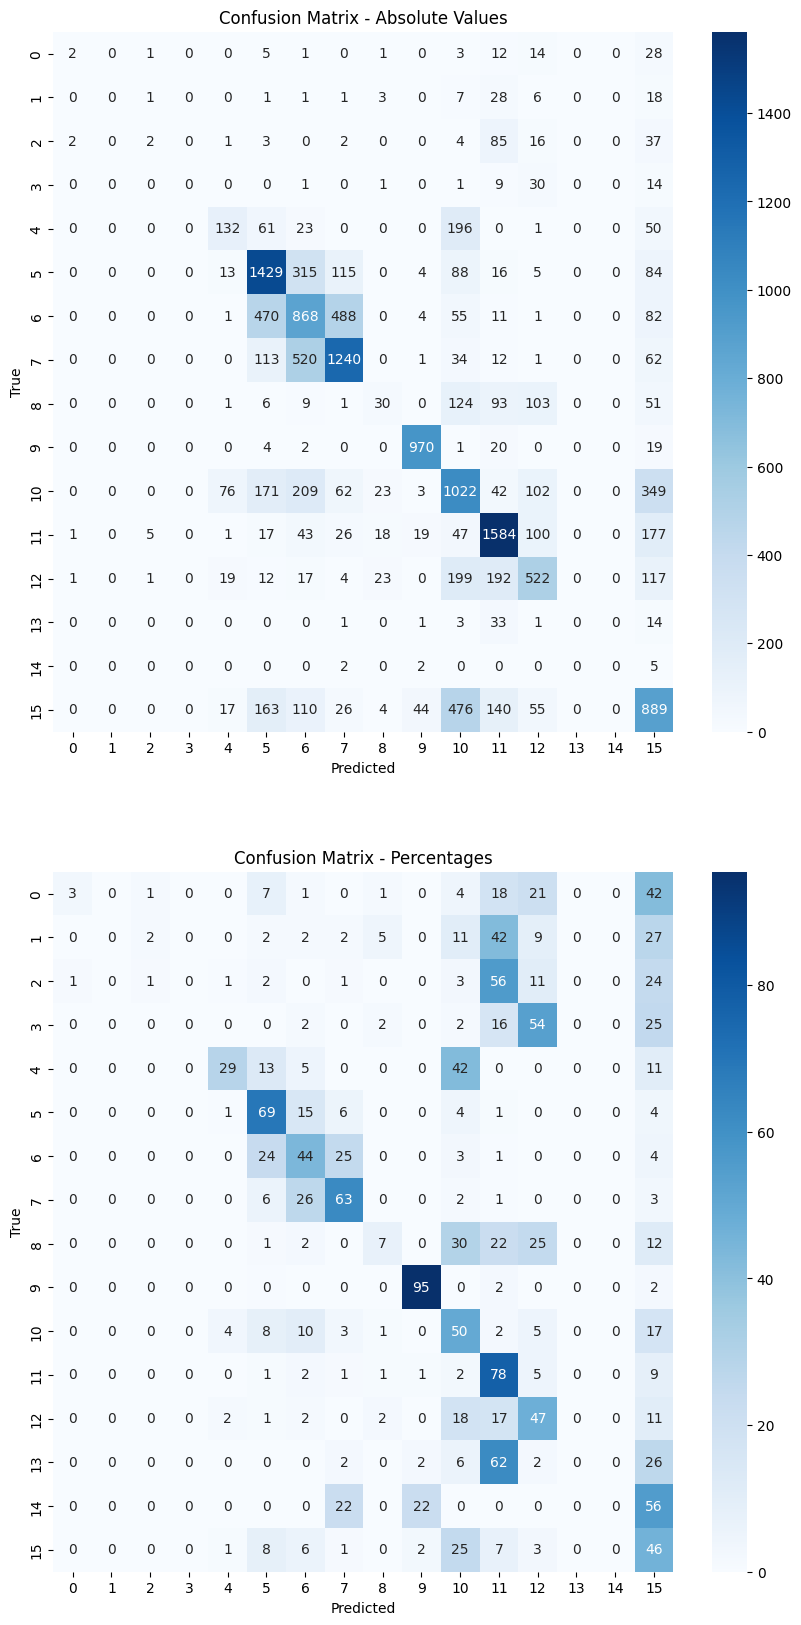

In [34]:
plot_confusion(y_true, y_pred)

In [35]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():

    for batch, masks in tqdm(train_dataloader):
        X, m, y = preprocess_batch(batch, masks)
        X, m = X.to(device), m.to(device)

        logits = model(X[:, :, 1:], m)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        y_pred.append(predicted_labels)
        y_true.append(y)

y_pred = torch.hstack(y_pred).cpu()
y_true = torch.hstack(y_true)

100%|███████████████████████████████████████████████████████████████| 242/242 [05:51<00:00,  1.45s/it]


In [36]:
(y_pred == y_true).sum() / len(y_true)

tensor(0.5589)

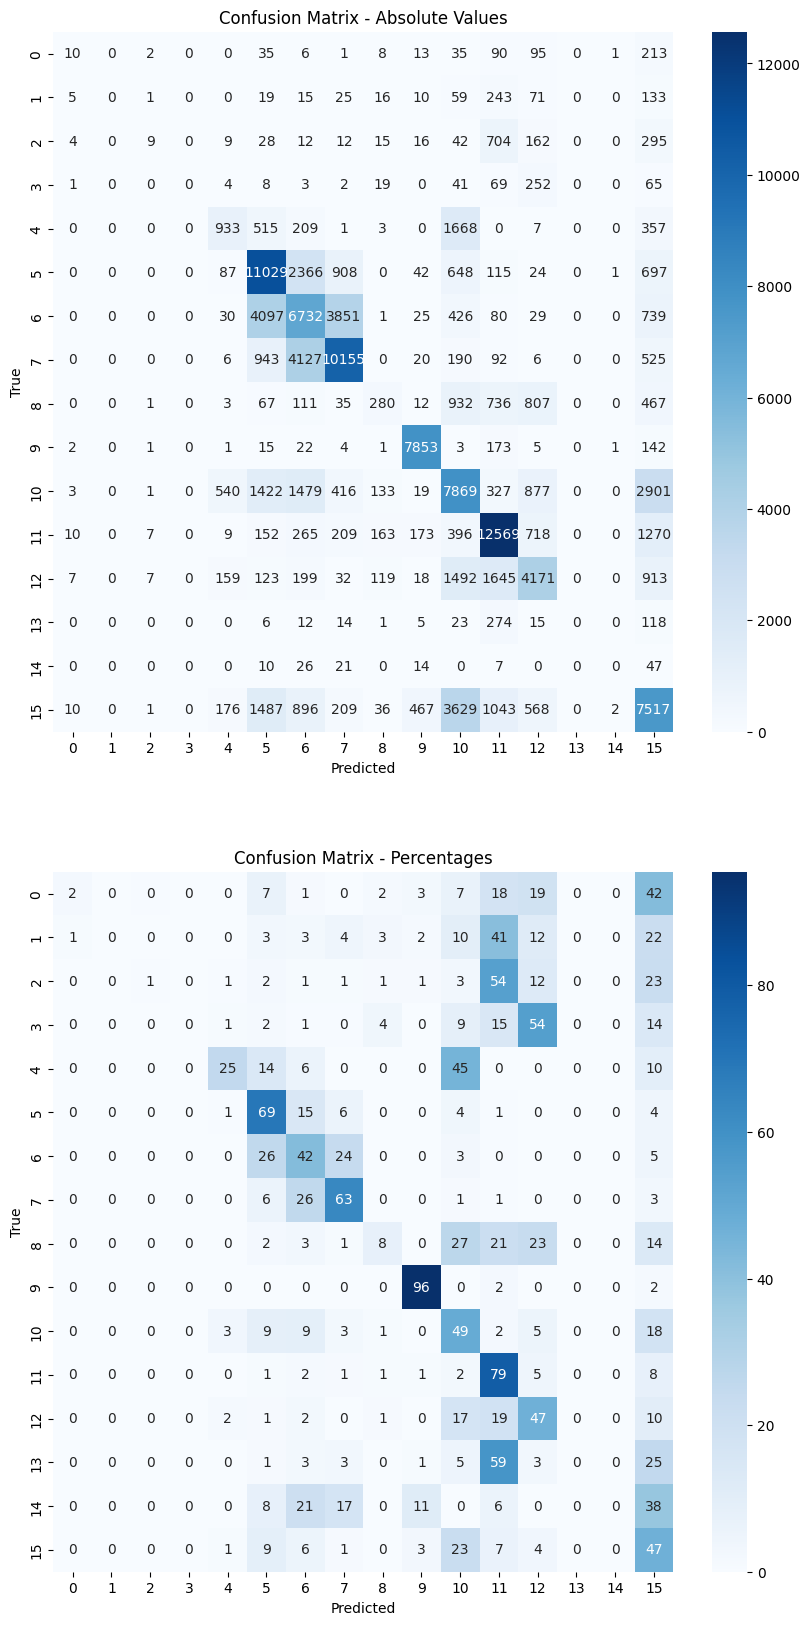

In [37]:
plot_confusion(y_true, y_pred)

In [28]:
ds_train.df['variable_type'].value_counts()

variable_type
SR       162262
EW        61762
EA        39323
ROT       29434
RRAB      26308
EB        20417
RRC        8891
M          8186
DSCT       3645
HADS       3544
DCEP       1271
CWB         593
CWA         503
RRD         477
DCEPS       458
RVA         116
Name: count, dtype: int64

In [29]:
value_counts = ds_train.df['variable_type'].value_counts()
classes_to_limit = value_counts[value_counts > 20000].index

In [30]:
classes_to_limit

Index(['SR', 'EW', 'EA', 'ROT', 'RRAB', 'EB'], dtype='object', name='variable_type')

In [31]:
for class_type in classes_to_limit:
    class_indices = ds_train.df[ds_train.df['variable_type'] == class_type].index
    indices_to_keep = np.random.choice(class_indices, size=20000, replace=False)    
    ds_train.df = ds_train.df.drop(index=set(class_indices) - set(indices_to_keep))

In [32]:
ds_train.df['variable_type'].value_counts()

variable_type
EB       20000
EW       20000
EA       20000
ROT      20000
SR       20000
RRAB     20000
RRC       8891
M         8186
DSCT      3645
HADS      3544
DCEP      1271
CWB        593
CWA        503
RRD        477
DCEPS      458
RVA        116
Name: count, dtype: int64

In [46]:
val_epoch()

100%|█████████████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.89s/it]

Val Total Loss: 1.79751 Accuracy: 0.374


In [50]:
torch.save(model.state_dict(), 'weight.pth')

In [19]:
encoder(inputs_embeds=X[:, :, 1:], attention_mask=m).last_hidden_state

tensor([[[-0.9506, -1.0241, -1.0530,  ...,  0.9812,  1.0417,  0.9451],
         [ 0.7102,  0.2792, -0.0825,  ...,  0.9809,  1.0477,  0.9524],
         [ 0.8573,  0.9642,  0.7275,  ...,  0.9739,  1.0498,  0.9607],
         ...,
         [ 0.8280, -0.4950, -1.4916,  ...,  1.1379,  1.1633,  1.1398],
         [-0.4524, -1.4348, -1.7933,  ...,  1.1615,  1.1949,  1.1696],
         [-1.6544, -1.8386, -1.7175,  ...,  1.1555,  1.1971,  1.1681]],

        [[-1.0414, -0.9149, -0.8234,  ...,  1.0566,  1.0201,  1.0146],
         [ 0.6124,  0.3958,  0.1637,  ...,  1.0612,  1.0240,  1.0267],
         [ 0.7576,  1.0800,  0.9744,  ...,  1.0536,  1.0248,  1.0344],
         ...,
         [ 0.7786, -0.4324, -1.3649,  ...,  1.1770,  1.1506,  1.1753],
         [-0.4901, -1.3836, -1.6932,  ...,  1.1920,  1.1849,  1.1972],
         [-1.6989, -1.7630, -1.5743,  ...,  1.1934,  1.1788,  1.2022]],

        [[-0.9525, -1.0261, -1.0523,  ...,  0.9826,  1.0414,  0.9448],
         [ 0.7082,  0.2771, -0.0820,  ...,  0

In [249]:
def train_epoch():
    model.train()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0
    
    for batch in train_dataloader:
        _, times, _, values, _, mask, aux, labels = batch
        labels = labels.to(device)
        values, mask = values.to(device), mask.to(device)
    
        optimizer.zero_grad()
    
        logits = model(values, mask)
        loss = criterion(logits, labels)
        total_loss.append(loss.item())
    
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
    
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
    
        loss.backward()
        optimizer.step()

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}', end=' ')

In [250]:
def val_epoch():
    model.eval()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            _, times, _, values, _, mask, aux, labels = batch
            labels = labels.to(device)
            values, mask = values.to(device), mask.to(device)

            logits = model(values, mask)
            loss = criterion(logits, labels)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()

            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

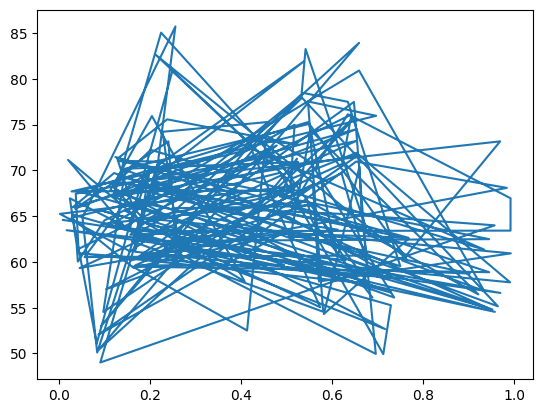

In [239]:
plt.plot(X[0, :, 0], X[0, :, 1])

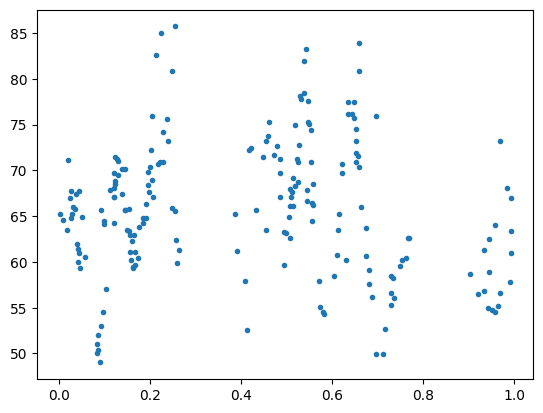

In [240]:
plt.plot(X[0, :, 0], X[0, :, 1], '.')

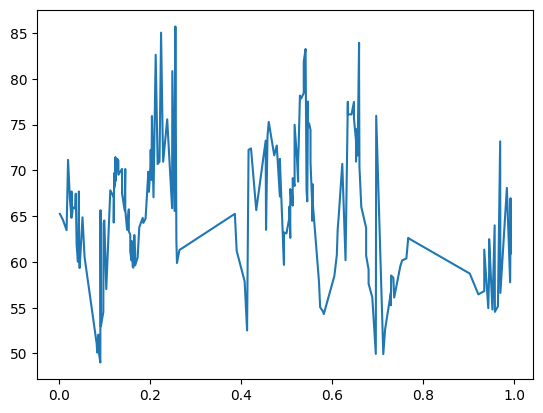

In [242]:
plt.plot(sorted_X[0, :, 0], sorted_X[0, :, 1])

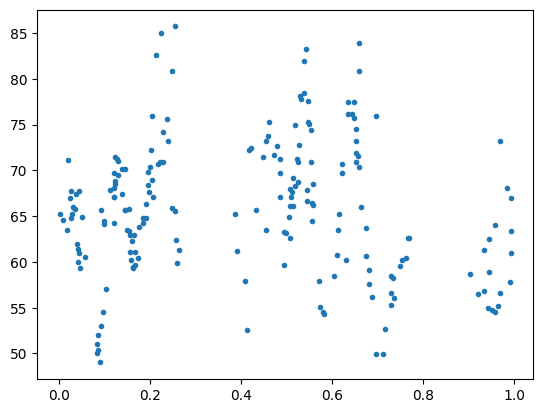

In [243]:
plt.plot(sorted_X[0, :, 0], sorted_X[0, :, 1], '.')

In [144]:
(sorted_X[0, :, 0] * ~sorted_mask[0]).sum()

tensor(90.4022)

In [145]:
sorted_X[0, :, 0].sum()

tensor(90.4022)

In [152]:
m

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.int32)

In [182]:
classes.shape

torch.Size([128])

Using cuda


In [69]:
model = TimeSeriesTransformerModel(config)
model = embedder.to(device)

In [79]:
encoder = TimeSeriesTransformerEncoder(config)
# encoder = encoder.to(device)

In [56]:
lcs.shape

torch.Size([128, 1, 3, 570])

In [60]:
lcs = lcs.transpose(1, -1)
lcs.shape

torch.Size([128, 570, 3, 1])

In [74]:
enc_input = lcs[:, :, 1:, 0]
# enc_input = enc_input.to(device)
enc_input.shape

torch.Size([128, 570, 2])

In [90]:
lcs_mask = lcs_mask.transpose(1, -1)
lcs_mask.shape

torch.Size([128, 570, 3, 1])

In [93]:
(lcs_mask[:, :, 1, 0] != lcs_mask[:, :, 2, 0]).sum()

tensor(0)

In [94]:
attention_mask = lcs_mask[:, :, 1, 0]
attention_mask.shape

torch.Size([128, 570])

In [95]:
# inputs_embeds `torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size) 128 570 2
encoder_outputs = encoder(
    inputs_embeds=enc_input,
    attention_mask=attention_mask,
    head_mask=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
)

In [104]:
past_time_features = lcs[:, :, 0, 0:]
past_time_features.shape

torch.Size([128, 570, 1])

In [96]:
encoder_outputs.last_hidden_state.shape

torch.Size([128, 570, 64])

In [29]:
model = ClassificationModel(pretrained_model=embedder, device=device)
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)
criterion = nn.CrossEntropyLoss()

In [35]:
values = lcs[:, 0, 1, :]
time_features = lcs[:, 0, 0, :]
observed_mask = masks[0][:, 0, 0, :]

In [37]:
values.shape, time_features.shape, observed_mask.shape

(torch.Size([128, 570]), torch.Size([128, 570]), torch.Size([128, 570]))

In [ ]:
outputs = self.pretrained_model(
    past_time_features=past_times.to(self.device),
    past_values=past_values.to(self.device),
    future_time_features=future_times.to(self.device),
    past_observed_mask=past_mask.to(self.device),
    static_real_features=static_real_features
)

# embedding = torch.mean(outputs.encoder_last_hidden_state, dim=1)
embedding = outputs.encoder_last_hidden_state[:, 0, :]
logits = self.classifier(embedding)